# 1. Setup

## 1a. Install required packages

In [ ]:
!pip install geopandas
!pip install Shapely

In [163]:
# Silence warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# CSV management
import pandas as pd

# Downloads and path management
import requests
import pathlib
import os

# Geographic analysis
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import MultiLineString
from shapely.ops import split

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dates
from datetime import datetime

# Numerical
import numpy as np

## 1b. Set filepaths

In [2]:
path = pathlib.Path().resolve()
INPUT_FILEPATH = path / "data"
OUTPUT_FILEPATH = path / "data" / "outputs"

## 1c. Load required data

In [3]:
# Geographic data
ct_boundaries = gpd.read_file(OUTPUT_FILEPATH / "ct_boundaries.gpkg")
ct_subcounties = gpd.read_file(OUTPUT_FILEPATH / "ct_subcounties.gpkg")
ct_zips = gpd.read_file(OUTPUT_FILEPATH / "ct_zips.gpkg")

# Routes
state_routes= gpd.read_file(OUTPUT_FILEPATH / "state_routes.gpkg" )
local_roads = gpd.read_file(OUTPUT_FILEPATH / "local_roads.gpkg" )
interstates = gpd.read_file(OUTPUT_FILEPATH / "interstates.gpkg")
ramps       = gpd.read_file(OUTPUT_FILEPATH / "ramps.gpkg")
                              
# Charging points
charging_points = gpd.read_file(OUTPUT_FILEPATH / "afdc_ct_charging_points.gpkg")  

# Income data (with subcounty geographies)
subcounties_income = gpd.read_file(OUTPUT_FILEPATH / "ct_subcounties_income_merged.gpkg")

In [4]:
# EV Purchase data
vehicle_reg_by_year = pd.read_csv(OUTPUT_FILEPATH /"vehicle_sales_by_year.csv" )

In [5]:
# EV Purchase data by zip, with geographic data
ev_purchases_by_zip_geo = gpd.read_file(OUTPUT_FILEPATH / "ev_sales_by_zip_geo.gpkg")

# 2. Outputs

## 2a. CT Road Network & Charging Points

Text(0.5, 0.01, 'Source: NREL Alternative Fuels Data Center Database')

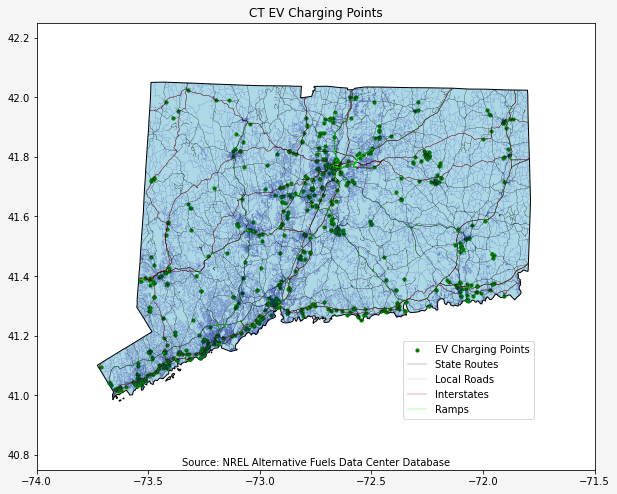

In [5]:
# Create figure and axes
fig, ax = plt.subplots(figsize = (10,10), facecolor = 'whitesmoke')

# Set axes sizes
ax.set_ylim(40.75, 42.25)
ax.set_xlim(-74, -71.5)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax, color = 'lightblue', edgecolor = 'black')

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='darkred', linewidth = 0.3, label = "Interstates")

# Plot ramps
ramps_plot = ramps.plot(ax=ax, color='lime', linewidth = 0.3, label = "Ramps")

# We get our handles and labels
handles, labels = ax.get_legend_handles_labels()

# Choose to place this within the figure, not within the axes
ax.legend(handles, labels, loc = 'upper right', bbox_to_anchor = (0.9, 0.3))

ax.set_title("CT EV Charging Points")
plt.text(s = "Source: NREL Alternative Fuels Data Center Database",
         x = 0.5,
         y= 0.01,
         transform=ax.transAxes,
         horizontalalignment='center')

## 2b. Charging Network & Median Income

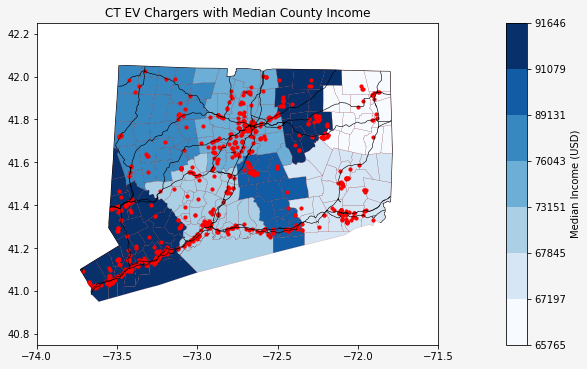

In [115]:
# Map
# Plot these
# Create figure and axes
fig, ax = plt.subplots(figsize = (10,10), facecolor = 'whitesmoke')


# Split them
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = 0)

# Set axes sizes
ax.set_title("CT EV Chargers with Median County Income")
ax.set_ylim(40.75, 42.25)
ax.set_xlim(-74, -71.5)

# Create a colormap
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(sorted(subcounties_income["Median"].unique()), cmap.N)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax,
              cax=cax,
              color = 'lightblue',
              edgecolor = 'black')

# Plot the counties
# Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
# Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
subcounties_income.plot(ax=ax,
                        column = "Median",
                        cax=cax,
                        cmap = cmap, norm=norm, legend = True,
                        legend_kwds={"label": "Median Income (USD)",
                                    "pad" : 0})
# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, cax=cax,
                color = 'red', 
                markersize =10,
                label = "EV Charging Points")

# Plot county subdivisions
counties_sub_plot = ct_subcounties.plot(ax=ax, cax=cax,
                    edgecolor = 'darkred',
                    facecolor = 'none',
                    linewidth = 0.1)


# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, cax=cax, color ='black', linewidth = 0.6, label = "Interstates")

plt.show()



## 2bi. Number of chargers by income

In [109]:
# Create a blank column
charging_points["GEOID"] = 0

# Loop through all charging points
for i in range(len(charging_points)):
    # Loop through all subcounties
    for j in range(len(subcounties_income)):
        if charging_points["geometry"][i].within(subcounties_income["geometry"][j]):
            charging_points.iloc[i, charging_points.columns.isin(["GEOID"])] = subcounties_income["GEOID"][j]
            
# Number of chargers by GEOID
charging_points_by_geoid = charging_points.groupby("GEOID").sum()[["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count"]].reset_index()

# Get add median income
charging_points_by_geoid_income = charging_points_by_geoid.merge(subcounties_income[["GEOID","Median"]], 
                                                                                    left_on = "GEOID",
                                                                                   right_on = "GEOID")

# Prepare the data to be plotted
charging_points_by_geoid_income = charging_points_by_geoid_income.sort_values("Median")
charging_points_by_geoid_income["Median"] = charging_points_by_geoid_income["Median"].astype(str)
charging_points_by_geoid_income = charging_points_by_geoid_income.groupby("Median").sum().reset_index()

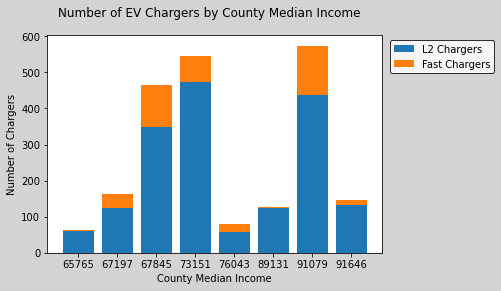

In [160]:
# Create figure
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'lightgrey')

# Add L2
l2 = ax.bar(x = "Median",
       height = "EV Level2 EVSE Num",
       align = 'center',
       data = charging_points_by_geoid_income,
       width = 0.8,
       label = "L2 Chargers")

# Add L3
l3 = ax.bar(x = "Median",
       height = "EV DC Fast Count",
       align = 'center',
       data =charging_points_by_geoid_income ,
       bottom = "EV Level2 EVSE Num",
       width = 0.8,
       label = "Fast Chargers")

# Set labels and legend
ax.set_xlabel("County Median Income")
ax.set_ylabel("Number of Chargers")
plt.legend(bbox_to_anchor = (1.35,1), 
           edgecolor = 'black')

# Add title
plt.suptitle("Number of EV Chargers by County Median Income")
plt.show()

## 2c. Fuel type over time

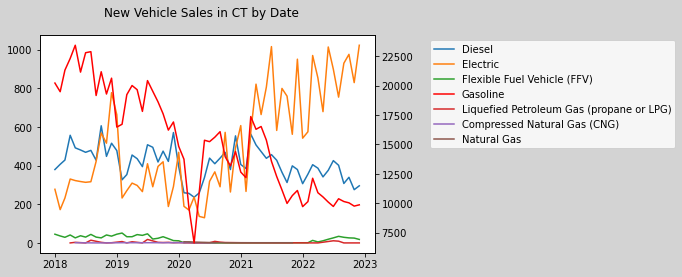

In [47]:
lns = None

# Make datetime
vehicle_reg_by_year['Date']= pd.to_datetime(vehicle_reg_by_year['Date'])

# Plot this
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'lightgrey')

# Do with categories
for fueltype in vehicle_reg_by_year["FuelTypePrimary"].unique():
    i = 0
    if fueltype != "Gasoline":
        ln = ax.plot(vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["Date"],
               vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["VEH_COUNT"],
               label = fueltype)
        
        # Add legends together
        try:
            lns = lns + ln
        except:
            lns = ln
    else:
        ax2 = ax.twinx()
        ln2 = ax2.plot(vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["Date"],
               vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["VEH_COUNT"],
               label = fueltype,
               color = 'red')
        lns += ln2


labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor = (1.15, 1))

#ax.legend(bbox_to_anchor = (1.2, 1))
# ax2.legend(bbox_to_anchor = (0.7, 0.2))

fig.suptitle("New Vehicle Sales in CT by Date")
plt.show()

## 2d. EV Sales as percentage of total by ZIP

### Data Preparation

### Plotting

C:\Users\rajan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


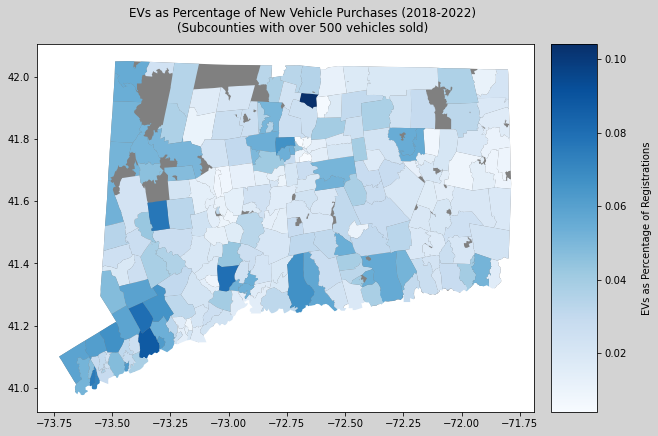

In [192]:
# Restrict to geographies with vehicle sales above 100
ev_purchases_by_zip_geo_filtered = ev_purchases_by_zip_geo[ev_purchases_by_zip_geo["TOTAL_VEH_COUNT"]>500]

# Clean up
ev_purchases_by_zip_geo_filtered["Percentage"] = ev_purchases_by_zip_geo_filtered["Percentage"] /100

# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'lightgrey')

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "EVs as Percentage of Registrations",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Add title
fig.suptitle("EVs as Percentage of New Vehicle Purchases (2018-2022)\n(Subcounties with over 500 vehicles sold)", y = 0.78)

# plt.legend()

plt.tight_layout()
plt.show()

C:\Users\rajan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


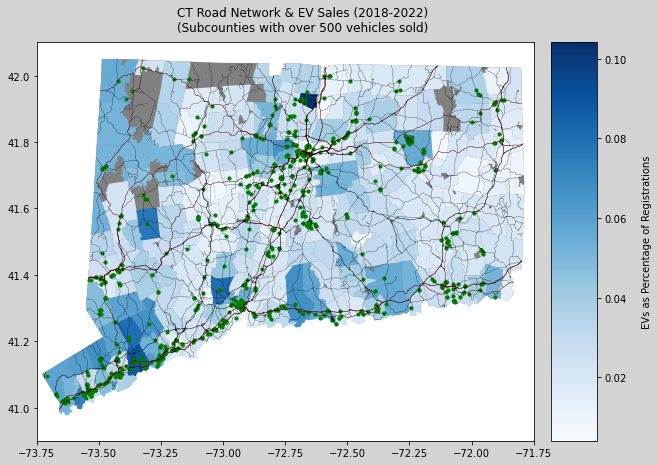

In [190]:
# Restrict to geographies with vehicle sales above 100
ev_purchases_by_zip_geo_filtered = ev_purchases_by_zip_geo[ev_purchases_by_zip_geo["TOTAL_VEH_COUNT"]>500]

# Clean up
ev_purchases_by_zip_geo_filtered["Percentage"] = ev_purchases_by_zip_geo_filtered["Percentage"] /100

# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'lightgrey')
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "EVs as Percentage of Registrations",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='darkred', linewidth = 0.3, label = "Interstates")

# Add title
fig.suptitle("CT Road Network & EV Sales (2018-2022)\n(Subcounties with over 500 vehicles sold)", y = 0.80)

plt.tight_layout()
plt.show()

# Mapping percentages by county

## Import data

First, import purchase data by county from `vehicle_data.ipynb`

In [91]:
# Import EV purchases by county
ev_purchases_cty_pctg_raw = pd.read_csv(OUTPUT_FILEPATH / "vehicle_sales_by_cty_pctg.csv")

# Drop unneeded columns
ev_purchases_cty_pctg_raw = ev_purchases_cty_pctg_raw.drop("Unnamed: 0", axis = 1)

# Clean up COUNTY_SUB
ev_purchases_cty_pctg_raw ["COUNTY_SUB"]= ev_purchases_cty_pctg_raw["COUNTY_SUB"].astype(int)

In [93]:
# Number of unique counties
ev_purchases_cty_pctg_raw["COUNTY_SUB"].nunique()

122

Filter by only subcounties with more than 500 EVs sold

In [92]:
counties_to_drop = list(ev_purchases_cty_pctg_raw.groupby("COUNTY_SUB").sum().sort_values("VEH_COUNT").head(13)["VEH_COUNT"].index)
counties_to_drop

[900371390,
 901134250,
 901133900,
 900148620,
 900118500,
 900183430,
 900312270,
 901144210,
 901369220,
 900517240,
 901344910,
 900722490,
 900516050]

In [96]:
# Keep EVs only
ev_purchases_cty_pctg_filtered = ev_purchases_cty_pctg_raw[ev_purchases_cty_pctg_raw["FuelTypePrimary"] == "Electric"]
ev_purchases_cty_pctg_filtered["COUNTY_SUB"].nunique()

117

In [102]:
# Drop counties with less than 500 total vehicles sold
ev_purchases_cty_pctg_filtered = ev_purchases_cty_pctg_filtered[~ev_purchases_cty_pctg_filtered["COUNTY_SUB"].isin(counties_to_drop)]
ev_purchases_cty_pctg_filtered["COUNTY_SUB"] = ev_purchases_cty_pctg_filtered["COUNTY_SUB"].astype(int)

len(ev_purchases_cty_pctg_filtered)

109

## Merge with geographic data

In [56]:
counties_shapefile.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,09,005,60750,00213489,0900560750,Plymouth,Plymouth town,43,T1,G4040,790,73450,NaN,A,56650624,1199855,+41.6663915,-073.0265164,"POLYGON ((-73.06467 41.64182, -73.06439 41.643..."
1,09,001,00000,00000000,0900100000,County subdivisions not defined,County subdivisions not defined,00,Z9,G4040,NaN,NaN,NaN,F,0,302385073,+41.0779471,-073.2165184,"POLYGON ((-73.45646 40.99116, -73.45646 41.013..."
2,09,001,56060,00213481,0900156060,Norwalk,Norwalk town,43,T5,G4040,720,71950,NaN,C,59275235,34928558,+41.0927388,-073.4197955,"POLYGON ((-73.47456 41.11470, -73.47441 41.114..."
3,09,001,04720,00213390,0900104720,Bethel,Bethel town,43,T1,G4040,720,72850,NaN,A,43918201,156161,+41.3697777,-073.3895032,"POLYGON ((-73.43502 41.37240, -73.43457 41.373..."
4,09,001,08070,00213396,0900108070,Bridgeport,Bridgeport town,43,T5,G4040,720,71950,NaN,C,41606698,8705768,+41.1873933,-073.1957567,"POLYGON ((-73.24409 41.22660, -73.24340 41.226..."


In [103]:
# Prepare to merge
counties_shapefile_formerge = counties_shapefile.copy(deep = True)
counties_shapefile_formerge["GEOID"] = counties_shapefile_formerge["GEOID"].astype(int)

In [104]:
# Merge
counties_geo_ev_purchases = counties_shapefile_formerge.merge(ev_purchases_cty_pctg_filtered, how = 'left',
                                                             left_on = 'GEOID', right_on = 'COUNTY_SUB')

In [105]:
counties_geo_ev_purchases

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTY_SUB,FuelTypePrimary,VEH_COUNT,Percentage
0,09,5,60750,00213489,900560750,Plymouth,Plymouth town,43,T1,G4040,...,A,56650624,1199855,+41.6663915,-073.0265164,"POLYGON ((-73.06467 41.64182, -73.06439 41.643...",900560750.0,Electric,205.0,1.183876
1,09,1,00000,00000000,900100000,County subdivisions not defined,County subdivisions not defined,00,Z9,G4040,...,F,0,302385073,+41.0779471,-073.2165184,"POLYGON ((-73.45646 40.99116, -73.45646 41.013...",NaN,NaN,NaN,NaN
2,09,1,56060,00213481,900156060,Norwalk,Norwalk town,43,T5,G4040,...,C,59275235,34928558,+41.0927388,-073.4197955,"POLYGON ((-73.47456 41.11470, -73.47441 41.114...",900156060.0,Electric,547.0,3.390986
3,09,1,04720,00213390,900104720,Bethel,Bethel town,43,T1,G4040,...,A,43918201,156161,+41.3697777,-073.3895032,"POLYGON ((-73.43502 41.37240, -73.43457 41.373...",NaN,NaN,NaN,NaN
4,09,1,08070,00213396,900108070,Bridgeport,Bridgeport town,43,T5,G4040,...,C,41606698,8705768,+41.1873933,-073.1957567,"POLYGON ((-73.24409 41.22660, -73.24340 41.226...",900108070.0,Electric,120.0,1.785449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,09,11,71670,00213510,901171670,Sprague,Sprague town,43,T1,G4040,...,A,34294921,1491928,+41.6355702,-072.0775268,"POLYGON ((-72.11857 41.66164, -72.11328 41.660...",901171670.0,Electric,130.0,1.996008
169,09,11,78600,00213521,901178600,Voluntown,Voluntown town,43,T1,G4040,...,A,100924002,2137004,+41.5791925,-071.8312276,"POLYGON ((-71.88442 41.64120, -71.88439 41.641...",901178600.0,Electric,35.0,2.286088
170,09,11,80280,00213526,901180280,Waterford,Waterford town,43,T1,G4040,...,A,84696754,30653701,+41.3516858,-072.1468340,"POLYGON ((-72.21931 41.41212, -72.21746 41.412...",901180280.0,Electric,267.0,2.285763
171,09,15,62710,00213494,901562710,Putnam,Putnam town,43,T1,G4040,...,A,52588040,282510,+41.9080271,-071.8704519,"POLYGON ((-71.93367 41.91687, -71.93335 41.916...",NaN,NaN,NaN,NaN


In [107]:
counties_shapefile_formerge

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,09,5,60750,00213489,900560750,Plymouth,Plymouth town,43,T1,G4040,790,73450,NaN,A,56650624,1199855,+41.6663915,-073.0265164,"POLYGON ((-73.06467 41.64182, -73.06439 41.643..."
1,09,1,00000,00000000,900100000,County subdivisions not defined,County subdivisions not defined,00,Z9,G4040,NaN,NaN,NaN,F,0,302385073,+41.0779471,-073.2165184,"POLYGON ((-73.45646 40.99116, -73.45646 41.013..."
2,09,1,56060,00213481,900156060,Norwalk,Norwalk town,43,T5,G4040,720,71950,NaN,C,59275235,34928558,+41.0927388,-073.4197955,"POLYGON ((-73.47456 41.11470, -73.47441 41.114..."
3,09,1,04720,00213390,900104720,Bethel,Bethel town,43,T1,G4040,720,72850,NaN,A,43918201,156161,+41.3697777,-073.3895032,"POLYGON ((-73.43502 41.37240, -73.43457 41.373..."
4,09,1,08070,00213396,900108070,Bridgeport,Bridgeport town,43,T5,G4040,720,71950,NaN,C,41606698,8705768,+41.1873933,-073.1957567,"POLYGON ((-73.24409 41.22660, -73.24340 41.226..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,09,11,71670,00213510,901171670,Sprague,Sprague town,43,T1,G4040,NaN,76450,NaN,A,34294921,1491928,+41.6355702,-072.0775268,"POLYGON ((-72.11857 41.66164, -72.11328 41.660..."
169,09,11,78600,00213521,901178600,Voluntown,Voluntown town,43,T1,G4040,NaN,76450,NaN,A,100924002,2137004,+41.5791925,-071.8312276,"POLYGON ((-71.88442 41.64120, -71.88439 41.641..."
170,09,11,80280,00213526,901180280,Waterford,Waterford town,43,T1,G4040,NaN,76450,NaN,A,84696754,30653701,+41.3516858,-072.1468340,"POLYGON ((-72.21931 41.41212, -72.21746 41.412..."
171,09,15,62710,00213494,901562710,Putnam,Putnam town,43,T1,G4040,715,79600,NaN,A,52588040,282510,+41.9080271,-071.8704519,"POLYGON ((-71.93367 41.91687, -71.93335 41.916..."


In [109]:
# Check number of counties for which no match
sum(counties_geo_ev_purchases["COUNTY_SUB"].isna())

65

Therefore we have lost 65 counties for which we have no data, or the county had less than 500 vehicles sold overall.

## Plot

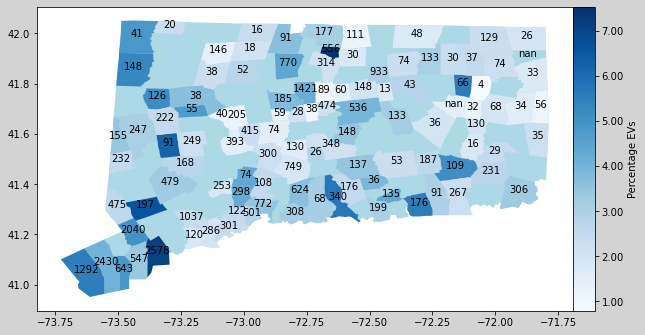

In [215]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'lightgrey')

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = 0)

# Add plots
ct_bg = ct_gdf.plot(ax=ax, facecolor = 'lightblue')


# Add zips and sales
counties_geo_ev_purchases.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "Percentage EVs",
                                  "pad" : 0,
                                    'format':"%.2f"})

centroids_df.plot(ax=ax, alpha = 0)


for x, y, label in zip(centroids_df.geometry.x, centroids_df.geometry.y, centroids_df.evs_purchased):
    ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", horizontalalignment = 'center')

In [213]:
# Get centroids
centroids = [P.centroid for P in counties_geo_ev_purchases["geometry"]]

centroids_df = gpd.GeoDataFrame(centroids, geometry = centroids)

centroids_df["evs_purchased"] = counties_geo_ev_purchases["VEH_COUNT"].astype('Int64').astype(str)[0:-2]

centroids_df = centroids_df.replace("<NA>", "")

# centroids_df["evs_purchased"] = centroids_df["evs_purchased"].fillna("")



# centroids_df["evs_purchased"] = counties_geo_ev_purchases["VEH_COUNT"].astype(str)



In [214]:
centroids_df

,0,geometry,evs_purchased
0,POINT (-73.02632578292435 41.664155149921136),POINT (-73.02633 41.66416),205
1,POINT (-73.21643163951228 41.077921825207426),POINT (-73.21643 41.07792),
2,POINT (-73.41942583368058 41.09295622155556),POINT (-73.41943 41.09296),547
3,POINT (-73.39283948009037 41.37471971590656),POINT (-73.39284 41.37472),
4,POINT (-73.19549482768005 41.18722771032603),POINT (-73.19549 41.18723),120
...,...,...,...
168,POINT (-72.07582803497233 41.63045194470015),POINT (-72.07583 41.63045),130
169,POINT (-71.83241902549099 41.57994888611712),POINT (-71.83242 41.57995),35
170,POINT (-72.14731137838213 41.35263572835362),POINT (-72.14731 41.35264),267
171,POINT (-71.87115548567411 41.90930896607098),POINT (-71.87116 41.90931),NaN


In [136]:
centroids_df

,0,geometry,evs_purchased
0,POINT (-73.02632578292435 41.664155149921136),POINT (-73.02633 41.66416),205.0
1,POINT (-73.21643163951228 41.077921825207426),POINT (-73.21643 41.07792),NaN
2,POINT (-73.41942583368058 41.09295622155556),POINT (-73.41943 41.09296),547.0
3,POINT (-73.39283948009037 41.37471971590656),POINT (-73.39284 41.37472),NaN
4,POINT (-73.19549482768005 41.18722771032603),POINT (-73.19549 41.18723),120.0
...,...,...,...
168,POINT (-72.07582803497233 41.63045194470015),POINT (-72.07583 41.63045),130.0
169,POINT (-71.83241902549099 41.57994888611712),POINT (-71.83242 41.57995),35.0
170,POINT (-72.14731137838213 41.35263572835362),POINT (-72.14731 41.35264),267.0
171,POINT (-71.87115548567411 41.90930896607098),POINT (-71.87116 41.90931),NaN


#  *** OLD ***

# Output: Chargers and Mean County Income

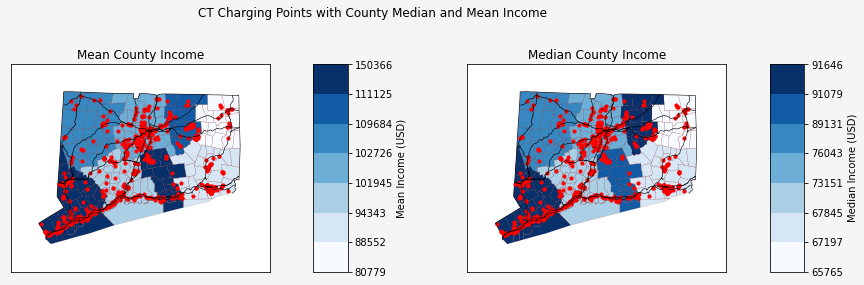

In [9]:
# Map
# Plot these
# Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols= 2, figsize = (15,5), facecolor = 'whitesmoke')

# Create separate axes for colorbars
caxs = [None, None]

# Create a title
fig.suptitle("CT Charging Points with County Median and Mean Income", x= 0.5, y = 0.95)

def create_axis(index, metric):
    ax = axs[index]
    caxs[index] = make_axes_locatable(ax)
    cax = caxs[index].append_axes("right", size = "10%", pad = "0%")
    
    # Divide
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("bottom", size = "4%", pad = 0)

    # Set axes sizes
    ax.set_title(f"{metric} County Income")
    ax.set_ylim(40.75, 42.25)
    ax.set_xlim(-74, -71.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xmargin(0)
    ax.set_ymargin(0)

    # Create a colormap
    cmap = plt.cm.Blues
    norm = colors.BoundaryNorm(sorted(subcounties_income[metric].unique()), cmap.N)

    # Plot state and points
    # Plot state boundaries
    ct_boundaries.plot(ax=ax,
                  cax=cax,
                  color = 'lightblue',
                  edgecolor = 'black')

    # Plot the counties
    # Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
    # Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
    subcounties_income.plot(ax=ax,
                            column = metric,
                            cax=cax,
                            cmap = cmap, norm=norm, legend = True,
                            legend_kwds={"label": f"{metric} Income (USD)",
                                        "pad" : 0,
                                        "orientation" : "vertical"})
    # Plot DCFC points
    afdc_plot = charging_points.plot(ax=ax, cax=cax,
                    color = 'red', 
                    markersize =10,
                    label = "EV Charging Points")

    # Plot county subdivisions
    counties_sub_plot = ct_subcounties.plot(ax=ax, cax=cax,
                        edgecolor = 'darkred',
                        facecolor = 'none',
                        linewidth = 0.1)


    # Plot state routes
    # state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

    # Plot local roads
    # local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

    # Plot interstates and US routes
    interstates_plot = interstates.plot(ax=ax, cax=cax, color ='black', linewidth = 0.6, label = "Interstates")

create_axis(0, "Mean")
create_axis(1, "Median")

# Set the figure title
# plt.title("CT Charging Stations with Mean and Median Income")

plt.show()